In [29]:
# interactive figure
%matplotlib widget

# auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import cmocean
import warnings
import gcm_filters
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import matplotlib.gridspec as gridspec
from dask.distributed import LocalCluster, Client
from matplotlib.colors import LinearSegmentedColormap, CenteredNorm, BoundaryNorm
from sys import platform
from xgcm import Grid
from scipy import integrate
from viztool import pcolor_center, pcolor_limits, get_pdf_of_icdf, config_colorbar, create_register_cmaps
# from spectrum import Gaussian_filter_2d
# from spectrum import TWODimensional_spec
from mixdiag import double_front_boundary, get_bld_Rib

In [3]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/derecho/scratch/zhihuaz/TracerInversion/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/TracerInversion/Data/'
else:
    print('OS not supported.')

create_register_cmaps()

### Calculate vertically integrated tracer and fluxes across $z = z_t$, mean MLD within the front after 2 days of cooling

In [30]:
# cname = 'd11_M003_Ri020_em01_Q001_W000_D000_St0_init-tracer-fluxed'
# dtop = 39

cname = 'd11_M006_Ri020_em01_Q001_W000_D000_St0_init-tracer-fluxed'
dtop = 30

ztop = -dtop
cvar = 'c8'
vars_to_drop = ['u', 'v', 'c7']
isubset_time = dict(time=slice(2,146,3))
ds = xr.open_dataset(data_dir+cname+'_state.nc', decode_timedelta=True).isel(isubset_time).chunk(time=1).drop_vars(vars_to_drop)
ds.close()
ds

<xarray.Dataset> Size: 74GB
Dimensions:  (zC: 64, zF: 65, xC: 2000, yF: 1000, xF: 2000, yC: 1000, time: 48)
Coordinates:
  * zC       (zC) float32 256B -142.8 -130.4 -121.2 ... -4.246 -2.548 -0.8492
  * zF       (zF) float32 260B -150.0 -135.6 -125.1 -117.3 ... -3.397 -1.698 0.0
  * xC       (xC) float32 8kB -3.998e+03 -3.994e+03 ... 3.994e+03 3.998e+03
  * yF       (yF) float32 4kB 0.0 4.0 8.0 12.0 ... 3.988e+03 3.992e+03 3.996e+03
  * xF       (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * yC       (yC) float32 4kB 2.0 6.0 10.0 14.0 ... 3.99e+03 3.994e+03 3.998e+03
  * time     (time) timedelta64[ns] 384B 4 days 01:00:00 ... 6 days 00:00:00
Data variables:
    c8       (time, zC, yC, xC) float32 25GB dask.array<chunksize=(1, 64, 1000, 2000), meta=np.ndarray>
    w        (time, zC, yC, xC) float32 25GB dask.array<chunksize=(1, 64, 1000, 2000), meta=np.ndarray>
    b        (time, zC, yC, xC) float32 25GB dask.array<chunksize=(1, 64, 1000, 2000), meta=np.ndarray>
Attributes: (12/80)
    σ_wind:                 0
    Ly:                     4000.0
    init_tracer:            1
    use_Stokes:             0
    n_per_set:              3.0
    save_ckp_interval:      86400.0
    ...                     ...
    tracer_reset_interval:  1
    Ny:                     1000
    output_prefix:          d11_M006_Ri020_em01_Q001_W000_D000_St0_init-trace...
    Oceananigans:           This file was generated using Oceananigans v0.95.12
    RiB₁:                   20.0
    ckp_prefix:             Q001_with-tracer-fluxed

In [31]:
periodic_coords = {dim : dict(left=f'{dim}F', center=f'{dim}C') for dim in 'xy'}
bounded_coords = {dim : dict(outer=f'{dim}F', center=f'{dim}C') for dim in 'z'}
coords = {dim : periodic_coords[dim] if tpl=='P' else bounded_coords[dim] for dim, tpl in zip('xyz', 'PPN')}
grid = Grid(ds, coords=coords)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message="The return type of `Dataset.dims` will*", category=FutureWarning)
    w_zf = grid.interp(ds.w,     axis='z', boundary='fill', fill_value=0)
    b_zf = grid.interp(ds.b,     axis='z', boundary='extend')
    c_zf = grid.interp(ds[cvar], axis='z', boundary='extend')
dzF  = ds.zF.sel(zF=slice(None, ztop+1)).diff('zF').data
cint = (ds[cvar].sel(zC=slice(None, ztop)).transpose(..., 'zC') * dzF).sum('zC')
w = w_zf.sel(zF=ztop, method='nearest')
b = b_zf.sel(zF=ztop, method='nearest')
c = c_zf.sel(zF=ztop, method='nearest')

filter_taper = gcm_filters.Filter(
               filter_scale=100,
               dx_min=4,
               filter_shape=gcm_filters.FilterShape.TAPER,
               transition_width=np.pi*4,
               grid_type=gcm_filters.GridType.REGULAR,
               )
cint.name = 'cint'
w.name = 'w'
b.name = 'b'
c.name = 'c'
dss = xr.merge([cint, w, b, c])
dss['xF']   = ds.xF
dss['yF']   = ds.yF
dss['time'] = ds.time
dssl = filter_taper.apply(dss, dims=['yC', 'xC'])

wp = dss.w - dssl.w
cp = dss.c - dssl.c
Rwc  = wp      * cp
wlcp = dssl.w  * cp
wpcl = wp      * dssl.c
wlcl = dssl.w  * dssl.c

Rwc.name  = 'Rwc'
wlcp.name = 'wlcp'
wpcl.name = 'wpcl'
wlcl.name = 'Lwc'
dsf = xr.merge([Rwc, wlcp, wpcl, wlcl])
dsf = dsf.assign_attrs(ds.attrs)
dsf['xF']   = ds.xF
dsf['yF']   = ds.yF
dsf['time'] = ds.time
dsf = filter_taper.apply(dsf, dims=['yC', 'xC'])
dsf['lwc'] = wlcl
dsf['Cwc'] = dsf.wlcp + dsf.wpcl # Clark flux
dsf['Lwc'] = dsf.Lwc  - wlcl     # Leonard flux
dsf['rwc'] = dsf.Rwc  + dsf.Cwc + dsf.Lwc # residual flux

In [32]:
dsf = xr.merge([dsf, dssl])
coords = {dim : periodic_coords[dim] if tpl=='P' else bounded_coords[dim] for dim, tpl in zip('xy', 'PP')}
grid = Grid(dssl, coords=coords)
dxF = dssl.xF.diff('xF').data[0]
dyF = dssl.yF.diff('yF').data[0]
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bl_xf = grid.interp(dssl.b, axis='x').transpose(..., 'xF')
    bl_yf = grid.interp(dssl.b, axis='y').transpose(..., 'yF')
    dbldx = grid.diff(bl_xf, axis='x') / dxF
    dbldy = grid.diff(bl_yf, axis='y') / dyF
M2l = np.sqrt(dbldx**2 + dbldy**2)/ds.attrs['M²']
dsf['mask_fz'] = double_front_boundary(M2l, Mc=0.15, in_km=0, out_km=0)

In [33]:
%%time
cluster = LocalCluster(n_workers=32, threads_per_worker=1, memory_limit='6GB',
                       local_directory='/glade/derecho/scratch/zhihuaz/temp', dashboard_address=':8787')
client = Client(cluster)
delayed_nc = dsf.to_netcdf(data_dir + cname + f'_{cvar}_budget_below_{dtop:02d}m.nc', compute=False)
delayed_nc.compute()

client.close()
cluster.close()

CPU times: user 1min 12s, sys: 35.7 s, total: 1min 48s
Wall time: 3min 51s


### Load data for budget calculation

In [34]:
cvar = 'c8'
dsf = xr.open_dataset(data_dir + cname + f'_{cvar}_budget_below_{dtop:02d}m.nc', decode_timedelta=True).chunk(time=1)
dsf.close()
dxF = (dsf.xF[1] - dsf.xF[0]).data
dyF = (dsf.yF[1] - dsf.yF[0]).data
dxy = dxF*dyF
dt  = dsf.save_out_interval*3
dsf['day'] = dsf.time/np.timedelta64(1, 'D')
dsf

<xarray.Dataset> Size: 5GB
Dimensions:  (xC: 2000, yC: 1000, time: 48, xF: 2000, yF: 1000)
Coordinates:
  * xC       (xC) float32 8kB -3.998e+03 -3.994e+03 ... 3.994e+03 3.998e+03
  * yC       (yC) float32 4kB 2.0 6.0 10.0 14.0 ... 3.99e+03 3.994e+03 3.998e+03
  * time     (time) timedelta64[ns] 384B 4 days 01:00:00 ... 6 days 00:00:00
    zF       float32 4B ...
  * xF       (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * yF       (yF) float32 4kB 0.0 4.0 8.0 12.0 ... 3.988e+03 3.992e+03 3.996e+03
Data variables: (12/13)
    Rwc      (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    wlcp     (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    wpcl     (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    Lwc      (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    lwc      (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    Cwc      (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    ...       ...
    cint     (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    w        (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    b        (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    c        (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    mask_fz  (time, yC, xC) float64 768MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    day      (time) float64 384B 4.042 4.083 4.125 4.167 ... 5.917 5.958 6.0
Attributes: (12/80)
    σ_wind:                 0
    Ly:                     4000.0
    init_tracer:            1
    use_Stokes:             0
    n_per_set:              3.0
    save_ckp_interval:      86400.0
    ...                     ...
    tracer_reset_interval:  1
    Ny:                     1000
    output_prefix:          d11_M006_Ri020_em01_Q001_W000_D000_St0_init-trace...
    Oceananigans:           This file was generated using Oceananigans v0.95.12
    RiB₁:                   20.0
    ckp_prefix:             Q001_with-tracer-fluxed

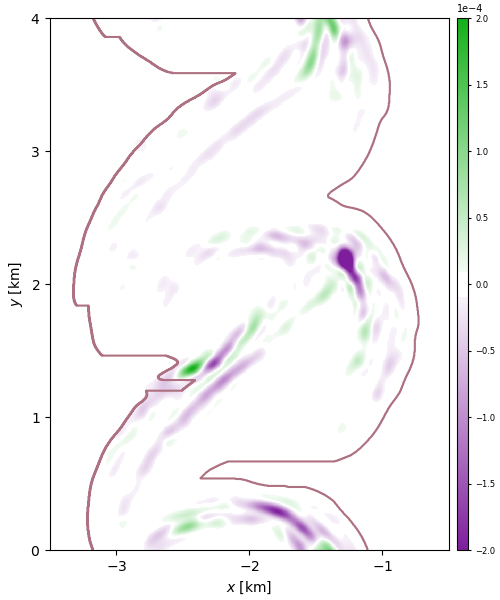

In [41]:
plt.close()
plt.figure(figsize=(5, 6), constrained_layout=True)

itime = -1

# pcm,_ = pcolor_center(dsf.w.isel(time=itime), cmap='w_ds')
pcm,_ = pcolor_center(dsf.rwc.isel(time=itime), cmap='cp_ds', smag=2e-4)
# pcm,_ = pcolor_limits(dsf.cint.isel(time=itime), cmap='c')
plt.contour(dsf.xC/1e3, dsf.yC/1e3, dsf.mask_fz.isel(time=itime), [0.5, 1.5], colors='xkcd:mauve')
# plt.contour(dsf.xC/1e3, dsf.yC/1e3, dsf.w.isel(time=itime), levels=np.array([-6, -3, 3 ,6])*1e-4, colors='k', linewidths=1)

config_colorbar(pcm)

# plt.title(r'$\bar{w} \bar{c}$')
# plt.title(r'$\overline{wc} - \bar{w} \bar{c}$')
# plt.title(r"$\overline{w'c'}$")
# plt.title(r"$\overline{\bar{w}c'} + \overline{w'\bar{c}}$")
# plt.title(r"$\overline{\bar{w}\bar{c}} - \bar{w} \bar{c}$")
# plt.title(r'$\int^{z_t}_{-L_z} \bar{c} \:dz$')

plt.gca().set_aspect('equal')
plt.gca().set_yticks(np.linspace(0,4,5))
plt.xlabel(r'$x$ [km]')
plt.ylabel(r'$y$ [km]');
plt.gca().set_xticks(np.linspace(-4,4,9));
# plt.ylim(1.4, 3.6)
plt.xlim(-3.5, -0.5);
# plt.xlim(1, 3);

In [37]:
cbgt0 = dsf.cint.sum(['xC', 'yC'])*dxy
cbgt0 = cbgt0 - cbgt0.isel(time=0)
cbgt1 = -integrate.cumulative_trapezoid(dsf.lwc.sum(['xC', 'yC'])*dxy, dx=dt, initial=0)
cbgt2 = -integrate.cumulative_trapezoid(dsf.rwc.sum(['xC', 'yC'])*dxy, dx=dt, initial=0)

cbdgt = np.stack([cbgt1, cbgt2])

In [38]:
cbgt1_nf = -integrate.cumulative_trapezoid(dsf.lwc.where(dsf.mask_fz != 1).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)
cbgt2_nf = -integrate.cumulative_trapezoid(dsf.rwc.where(dsf.mask_fz != 1).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)

cbgt1_fz = -integrate.cumulative_trapezoid(dsf.lwc.where(dsf.mask_fz == 1).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)
cbgt2_fz = -integrate.cumulative_trapezoid(dsf.rwc.where(dsf.mask_fz == 1).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)

cbdgt = np.stack([cbgt1_nf+cbgt2_nf, cbgt1_fz, cbgt2_fz])

In [14]:
cbgt2_fzR  = -integrate.cumulative_trapezoid(dsf.Rwc.where(dsf.mask_fz == 1).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)
cbgt2_fzLH = -integrate.cumulative_trapezoid(dsf.wlcp.where(dsf.mask_fz == 1).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)
cbgt2_fzHL = -integrate.cumulative_trapezoid(dsf.wpcl.where(dsf.mask_fz == 1).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)
cbgt2_fzL  = -integrate.cumulative_trapezoid(dsf.Lwc.where(dsf.mask_fz == 1).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)

cbdgt = np.stack([cbgt1_nf+cbgt2_nf, cbgt1_fz, cbgt2_fzR, cbgt2_fzLH, cbgt2_fzHL, cbgt2_fzL])

In [21]:
cbgt2_downwell = -integrate.cumulative_trapezoid(dsf.rwc.where((dsf.mask_fz == 1) & (dsf.w < 0)).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)
cbgt2_upwell   = -integrate.cumulative_trapezoid(dsf.rwc.where((dsf.mask_fz == 1) & (dsf.w > 0)).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)

cbdgt = np.stack([cbgt1_nf+cbgt2_nf, cbgt1_fz, cbgt2_downwell, cbgt2_upwell])

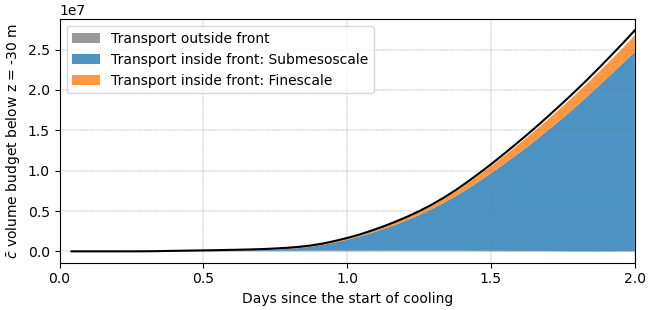

In [40]:
plt.close()
plt.figure(figsize=(6.5,3.1), constrained_layout=True)

day_of_cooling_start = 4
# plt.stackplot(dsf.day-day_of_cooling_start, cbdgt, 
#               labels=['Submesoscale transport', 'Residual transport'], alpha=0.8)

plt.stackplot(dsf.day-day_of_cooling_start, cbdgt, 
              labels=['Transport outside front',
                      'Transport inside front: Submesoscale',
                      'Transport inside front: Finescale'],
              colors=['gray', 'C0', 'C1'], alpha=0.8)

# plt.stackplot(dsf.day, cbdgt, 
#               labels=['Transport outside front',
#                       'Transport inside front: Submesoscale',
#                       'Transport inside front: Residual from Reynolds term',
#                       r"Transport inside front: Residual from Clark term $\overline{\bar{w}c'}$",
#                       r"Transport inside front: Residual from Clark term $\overline{w'\bar{c}}$",
#                       'Transport inside front: Residual from Leonard term'], alpha=0.8)

# plt.stackplot(dsf.day, cbdgt, 
#               labels=['Transport outside front',
#                       'Transport inside front: Submesoscale',
#                      r'Transport inside front: Residual @ $\bar{w}$ < 0',
#                      r'Transport inside front: Residual @ $\bar{w}$ > 0'], alpha=0.8)

plt.plot(dsf.day-day_of_cooling_start, cbgt0, 'k')
plt.legend()

plt.xlim(0, 2)
# plt.ylim(0, 1.45e8)
plt.grid(c='gray', ls='--', lw=0.3)
plt.gca().set_xticks(np.linspace(0,2,5))
plt.ylabel(rf'$\bar{{c}}$ volume budget below z = {ztop:02d} m')
plt.xlabel('Days since the start of cooling');